In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==================== Tiền xử lý dữ liệu ====================
train_dir = './Train'
val_dir = './Test'

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# ==================== Định nghĩa các lớp cho ViT ====================
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# ==================== Xây dựng mô hình Vision Transformer ====================
def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim,
                          transformer_layers, num_heads, mlp_units, num_classes):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_units, activation='gelu')(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(projection_dim, activation='gelu')(x3)
        x3 = layers.Dropout(0.1)(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = layers.Dense(mlp_units, activation='gelu')(representation)
    features = layers.Dropout(0.5)(features)
    logits = layers.Dense(num_classes, activation='softmax')(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# ==================== Khởi tạo và huấn luyện mô hình ====================
input_shape = (128, 128, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
transformer_layers = 8
num_heads = 4
mlp_units = 128
num_classes = train_generator.num_classes

vit_model = create_vit_classifier(
    input_shape, patch_size, num_patches, projection_dim,
    transformer_layers, num_heads, mlp_units, num_classes
)

vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = vit_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

test_loss, test_accuracy = vit_model.evaluate(val_generator)
print(f"\n\u0110\u1ed9 ch\u00ednh x\u00e1c tr\u00ean t\u1eadp ki\u1ec3m tra: {test_accuracy * 100:.2f}%")

vit_model.save('tool_recognition_vit_model.keras')



Found 2774 images belonging to 6 classes.
Found 1080 images belonging to 6 classes.



D:\DACN_3\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.1767 - loss: 2.4662

D:\DACN_3\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 549ms/step - accuracy: 0.1768 - loss: 2.4607 - val_accuracy: 0.1944 - val_loss: 1.7872
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.1926 - loss: 1.7869 - val_accuracy: 0.1944 - val_loss: 1.7823
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.1804 - loss: 1.7849 - val_accuracy: 0.1944 - val_loss: 1.7787
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.1903 - loss: 1.7816 - val_accuracy: 0.1944 - val_loss: 1.7759
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.1886 - loss: 1.7780 - val_accuracy: 0.1944 - val_loss: 1.7738
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.1861 - loss: 1.7784 - val_accuracy: 0.1944 - val_loss: 1.7720
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.1854 - loss: 1.7770 - val_accuracy: 0.1944 - val_loss: 1.7709
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.1748 - loss: 1.7745 - val_accuracy: 0.194

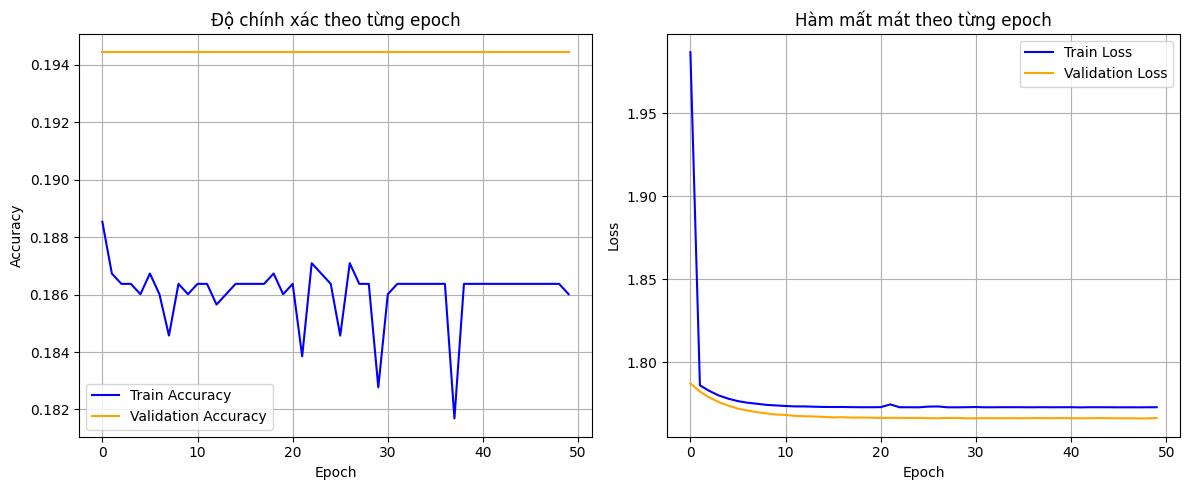

In [5]:
import matplotlib.pyplot as plt

# Vẽ độ chính xác (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Độ chính xác theo từng epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Vẽ hàm mất mát (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Hàm mất mát theo từng epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
